#### Setup and Data Download

[Data Documentation Kaggle](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)

[Data Documentation Instacart](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [2]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c instacart-market-basket-analysis

! unzip /content/instacart-market-basket-analysis.zip -d zipped_data

! unzip /content/zipped_data/aisles.csv.zip -d /content/data/
! unzip /content/zipped_data/departments.csv -d /content/data/
! unzip /content/zipped_data/order_products__prior.csv.zip -d /content/data/
! unzip /content/zipped_data/order_products__train.csv.zip -d /content/data/
! unzip /content/zipped_data/orders.csv.zip -d /content/data/
! unzip /content/zipped_data/products.csv.zip -d /content/data/ 

! rm -rf /content/instacart-market-basket-analysis.zip
! rm -rf /content/data/__MACOSX

 97% 191M/196M [00:02<00:00, 116MB/s]
100% 196M/196M [00:02<00:00, 86.3MB/s]
Archive:  /content/instacart-market-basket-analysis.zip
  inflating: zipped_data/aisles.csv.zip  
  inflating: zipped_data/departments.csv.zip  
  inflating: zipped_data/order_products__prior.csv.zip  
  inflating: zipped_data/order_products__train.csv.zip  
  inflating: zipped_data/orders.csv.zip  
  inflating: zipped_data/products.csv.zip  
  inflating: zipped_data/sample_submission.csv.zip  
Archive:  /content/zipped_data/aisles.csv.zip
  inflating: /content/data/aisles.csv  
   creating: /content/data/__MACOSX/
  inflating: /content/data/__MACOSX/._aisles.csv  
Archive:  /content/zipped_data/departments.csv.zip
  inflating: /content/data/departments.csv  
  inflating: /content/data/__MACOSX/._departments.csv  
Archive:  /content/zipped_data/order_products__prior.csv.zip
  inflating: /content/data/order_products__prior.csv  
  inflating: /content/data/__MACOSX/._order_products__prior.csv  
Archive:  /conten

### EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
aisles = pd.read_csv('/content/data/aisles.csv')
departments = pd.read_csv('/content/data/departments.csv')
prior_orders = pd.read_csv('/content/data/order_products__prior.csv')
train_orders = pd.read_csv('/content/data/order_products__train.csv')
orders = pd.read_csv('/content/data/orders.csv')
products = pd.read_csv('/content/data/products.csv')

Let's look at each of the files individually

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


From the Data Documentation - 

These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

In [10]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
print(f"Total Number of Distinct users : {orders['user_id'].nunique()}")
print(f'Distinct Aisles : ', aisles.shape[0])
print(f'Distinct Departments : ', departments.shape[0])
print(f'Distinct Orders : ', orders.shape[0])
print(f'Distinct Products : ', products.shape[0])
print(f'Total number of prior orders : ', prior_orders.shape[0])
print(f'Total number of train orders : ', train_orders.shape[0])

Total Number of Distinct users : 206209
Distinct Aisles :  134
Distinct Departments :  21
Distinct Orders :  3421083
Distinct Products :  49688
Total number of prior orders :  32434489
Total number of train orders :  1384617


### Busiest day of the week

As per multiple Github discussions, Day of the Week 0 maps to Sunday, and 6 to Saturday. We'll use the info to get the busiest day of the week!

In [13]:
map_daynum_to_dayname = {
    0 : 'Sunday',
    1 : 'Monday',
    2 : 'Tuesday',
    3 : 'Wednesday',
    4 : 'Thursday',
    5 : 'Friday',
    6 : 'Saturday'
}

# Create a subset of Order ID and Order Day of the Week from the orders dataframe
orders_subset = orders.loc[:, ['order_id', 'order_dow']]
# Map Day number to Day name
orders_subset['order_dow_name'] = orders.loc[:, 'order_dow'].map(map_daynum_to_dayname)
orders_subset.head()

,order_id,order_dow,order_dow_name
0,2539329,2,Tuesday
1,2398795,3,Wednesday
2,473747,3,Wednesday
3,2254736,4,Thursday
4,431534,4,Thursday


This worked fine!

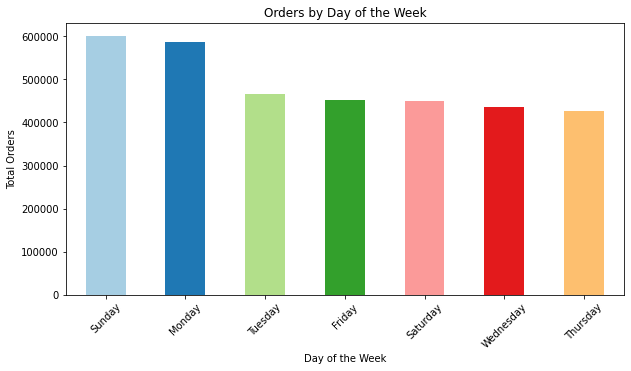

In [14]:
# Group by Day name, count Order IDs, and sort descending
orders_grouped = orders_subset.groupby(['order_dow_name'])['order_id'].count().sort_values(ascending=False)

# Plot the bar chart
orders_grouped.plot(kind='bar', title='Orders by Day of the Week', ylabel='Total Orders',
         xlabel='Day of the Week', figsize=(10, 5), rot = 45, color=plt.cm.Paired(np.arange(len(orders_grouped))));

Sundays and Mondays are busiest days of the week, while Thursday is the least busy

### Breakdown of Orders by Hour of the Day

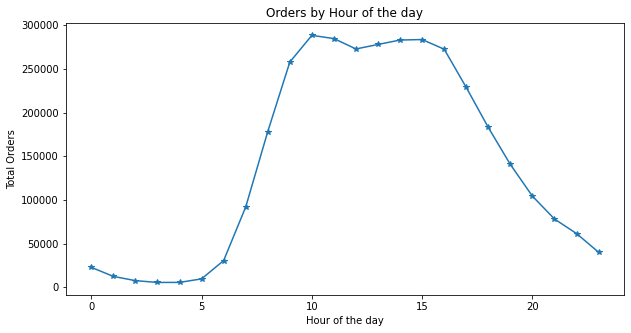

In [36]:
# Create a subset of Order ID and Order Day of the Week from the orders dataframe
orders_subset = orders.loc[:, ['order_id', 'order_hour_of_day']]

# Group by Day name, count Order IDs and sort descending
orders_grouped = orders_subset.groupby(['order_hour_of_day'])['order_id'].count()

# Create Line chart
orders_grouped.plot(style='-*', title='Orders by Hour of the day', ylabel='Total Orders',
         xlabel='Hour of the day', figsize=(10, 5));

### Max Products by Department

There are 21 Departments and total 49688 products. Let's see which Departments has maximum products

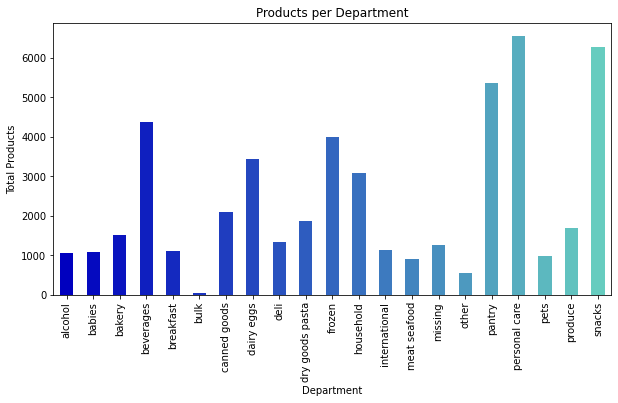

In [67]:
# Merge Products and Departments, and add Department Name to products df
products_df_with_dept_name = products.merge(departments, on='department_id',how='left')

# Group by Department and count products
prod_dept_grouped = products_df_with_dept_name.groupby(['department'])['product_id'].count()

# Define Color list - (r,g,b) values
my_colors = [(x/50.0, x/25.0, 0.75) for x in range(len(prod_dept_grouped))]

# Plot the bar chart
prod_dept_grouped.plot(kind='bar', stacked = True,title='Products per Department', ylabel='Total Products',
         xlabel='Department', figsize=(10, 5), rot = 90, color = my_colors);